# Exoplanet Hunting in Deep Space
### By Ali Shannon
In this module, I look at time series light intensity data provided by the Kepler Space Telescope to detect the presence of exoplanets.

The fields are explained here:

1. `LABEL` uses either 1 or 2, where 1 means the star has no orbiting planet and 2 means it has at least one.

2. `FLUX 1 : 3192` are the light intensity data retreived from each planet over some time interval.

I intend to analyze the plots then train a predictor that will understand the relationships between light intensity values and determine whether or not the star has at least one orbiting planet. 

For our purposes, we will assume that there are only two types of stars, ones with orbiting planets and ones with none.

### Acknowledgments

Data is retreived from **[Kaggle](https://www.kaggle.com/keplersmachines/kepler-labelled-time-series-data/home)**, check out their publicly available datasets for machine learning and data analysis.

In [1]:
import pandas as pd # data analysis
import scipy # stats and dependancies
import numpy as np # linear algebra
import matplotlib.pyplot as plt # plotting library
import seaborn as sns # statistics library
import IPython # shell commands

np.random.seed(42)

%matplotlib inline

df = pd.read_csv('exoTrain.csv')

In [2]:
y = df['LABEL']
# show the first 5 rows
df.head()

LABEL   FLUX.1   FLUX.2   FLUX.3   FLUX.4   FLUX.5   FLUX.6  FLUX.7  \
0      2    93.85    83.81    20.10   -26.98   -39.56  -124.71 -135.18   
1      2   -38.88   -33.83   -58.54   -40.09   -79.31   -72.81  -86.55   
2      2   532.64   535.92   513.73   496.92   456.45   466.00  464.50   
3      2   326.52   347.39   302.35   298.13   317.74   312.70  322.33   
4      2 -1107.21 -1112.59 -1118.95 -1095.10 -1057.55 -1034.48 -998.34   

    FLUX.8  FLUX.9  ...  FLUX.3188  FLUX.3189  FLUX.3190  FLUX.3191  \
0   -96.27  -79.89  ...     -78.07    -102.15    -102.15      25.13   
1   -85.33  -83.97  ...      -3.28     -32.21     -32.21     -24.89   
2   486.39  436.56  ...     -71.69      13.31      13.31     -29.89   
3   311.31  312.42  ...       5.71      -3.73      -3.73      30.05   
4 -1022.71 -989.57  ...    -594.37    -401.66    -401.66    -357.24   

   FLUX.3192  FLUX.3193  FLUX.3194  FLUX.3195  FLUX.3196  FLUX.3197  
0      48.57      92.54      39.32      61.42       5.08     -39.54  
1      -4.86       0.76     -11.70       6.46      16.00      19.93  
2     -20.88       5.06     -11.80     -28.91     -70.02     -96.67  
3      20.03     -12.67      -8.77     -17.31     -17.35      13.98  
4    -443.76    -438.54    -399.71    -384.65    -411.79    -510.54  

[5 rows x 3198 columns]

### Data visualization

This will display some statistics for the data sets. Blues are 1 (do not contain exoplanets) and Reds are 2 (contain at least one exoplanet)

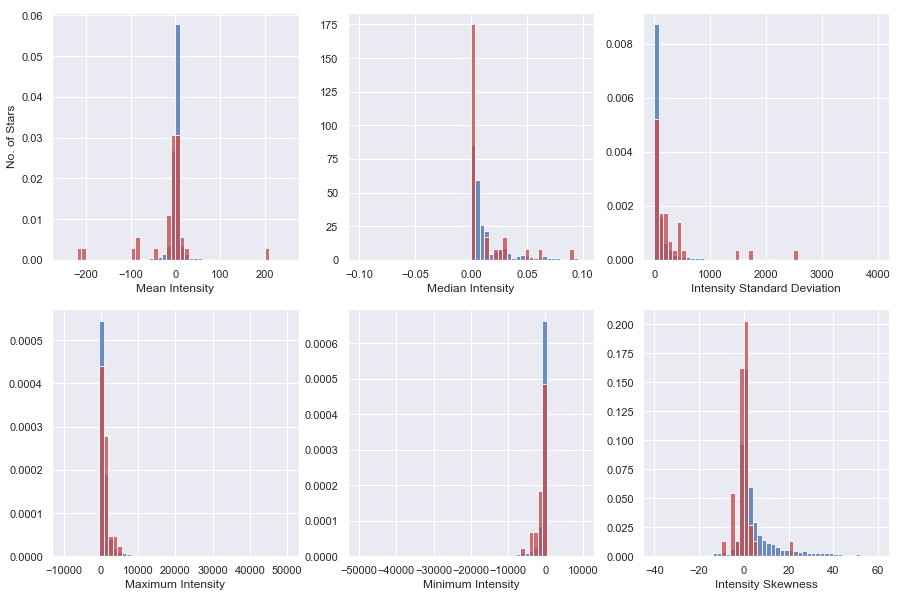

In [3]:
import warnings
warnings.filterwarnings("ignore") # remove featurewarnings

sns.set()

means1 = df[y==1].mean(axis=1)
medians1 = df[y==1].median(axis=1)
std1 = df[y==1].std(axis=1)
maxval1 = df[y==1].max(axis=1)
minval1 = df[y==1].min(axis=1)
skew1 = df[y==1].skew(axis=1)
means2 = df[y==2].mean(axis=1)
medians2 = df[y==2].median(axis=1)
std2 = df[y==2].std(axis=1)
maxval2 = df[y==2].max(axis=1)
minval2 = df[y==2].min(axis=1)
skew2 = df[y==2].skew(axis=1)

# plot each category
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(231)
ax.hist(means1,alpha=0.8,bins=50,color='b',normed=True,range=(-250,250))
ax.hist(means2,alpha=0.8,bins=50,color='r',normed=True,range=(-250,250))
ax.get_legend()
ax.set_xlabel('Mean Intensity')
ax.set_ylabel('No. of Stars')

ax = fig.add_subplot(232)
ax.hist(medians1,alpha=0.8,bins=50,color='b',normed=True,range=(-0.1,0.1))
ax.hist(medians2,alpha=0.8,bins=50,color='r',normed=True,range=(-0.1,0.1))
ax.get_legend()

ax.set_xlabel('Median Intensity')
ax = fig.add_subplot(233)
ax.hist(std1,alpha=0.8,bins=50,normed=True,color='b',range=(0,4000))
ax.hist(std2,alpha=0.8,bins=50,normed=True,color='r',range=(0,4000))
ax.get_legend()

ax.set_xlabel('Intensity Standard Deviation')
ax = fig.add_subplot(234)
ax.hist(maxval1,alpha=0.8,bins=50,normed=True,color='b',range=(-10000,50000))
ax.hist(maxval2,alpha=0.8,bins=50,normed=True,color='r',range=(-10000,50000))
ax.get_legend()

ax.set_xlabel('Maximum Intensity')
ax = fig.add_subplot(235)
ax.hist(minval1,alpha=0.8,bins=50,normed=True,color='b',range=(-50000,10000))
ax.hist(minval2,alpha=0.8,bins=50,normed=True,color='r',range=(-50000,10000))
ax.get_legend()

ax.set_xlabel('Minimum Intensity')
ax = fig.add_subplot(236)
ax.hist(skew1,alpha=0.8,bins=50,normed=True,color='b',range=(-40,60))
ax.hist(skew2,alpha=0.8,bins=50,normed=True,color='r',range=(-40,60)) 
ax.get_legend()

ax.set_xlabel('Intensity Skewness')

plt.show()

### Time varying data analysis.

This will sample out 12 stars of each category and plot the intensities over time.

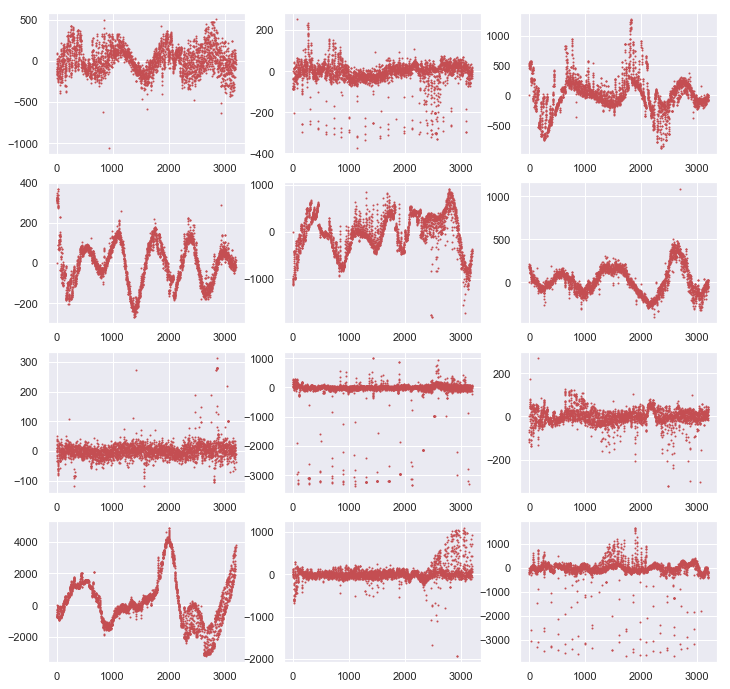

In [4]:
fig = plt.figure(figsize=(12,40))
t = np.array(range(3198))
for i in range(12):
    ax = fig.add_subplot(13,3,i+1)
    ax.scatter(t,df[y==2].iloc[i,:], s = 1, c = 'r')

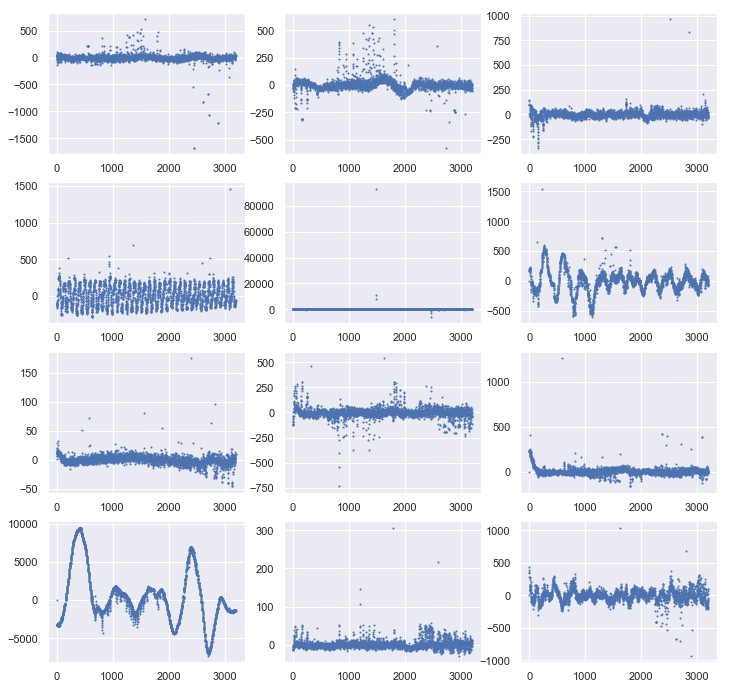

In [5]:
fig = plt.figure(figsize=(12,40))
t = np.array(range(3198))
for i in range(12):
    ax = fig.add_subplot(13,3,i+1)
    ax.scatter(t,df[y==1].iloc[i,:], s = 1, c = 'b')

Notice that the time varying data is far too difficult for simple boolean statements. We need to employ machine learning algorithms and train the models using this data. Then testing the models against new data to check the accuracy of each ML model.

#### Analysis of how balanced the dataset is.
This will look at the percentage of stars that contain planets versus the ones that don't. If the dataset is imbalanced, then we need to revise the training data since we want the ML model to decern the differences between the classifications of the stars rather than just classify all as the majority.

In [6]:
df['LABEL'].value_counts() # print the sums of each unique value

1    5050
2      37
Name: LABEL, dtype: int64

This seems pretty imbalanced. Let's look at the percentages:

In [7]:
print('Stars with no planets are', round(df['LABEL'].value_counts()[1]/len(df) * 100,2), '% of the dataset')
print('Stars with orbiting planets are', round(df['LABEL'].value_counts()[2]/len(df) * 100,2), '% of the dataset')

Stars with no planets are 99.27 % of the dataset
Stars with orbiting planets are 0.73 % of the dataset


The data is far too *Imbalanced*. Thus we need to somehow balance the dataset before applying machine learning or else it will just classify all stars as they have no exoplanets instead of learning the differences.

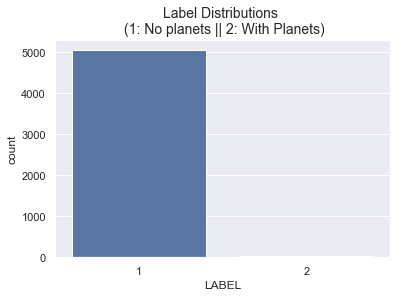

In [8]:
sns.countplot('LABEL', data=df)
plt.title('Label Distributions \n (1: No planets || 2: With Planets)', fontsize=14);

Undersample the dataset to account for imbalanced datasets.

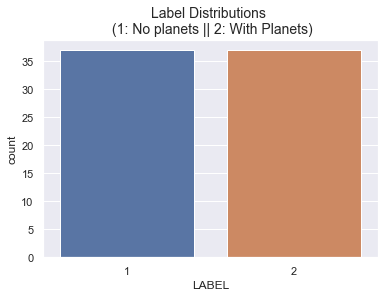

In [9]:
label_1 = df[df['LABEL'] == 1]
label_2 = df[df['LABEL'] == 2]


sample_size = sum(df['LABEL'] == 2)
random_indices = np.random.choice(label_1.index, sample_size, replace=False)
under_sample_idx = np.concatenate([random_indices, label_2.index])
under_sample_idx = np.random.permutation(under_sample_idx)
under_sample = df.loc[under_sample_idx]

sns.countplot('LABEL', data=under_sample)
plt.title('Label Distributions \n (1: No planets || 2: With Planets)', fontsize=14);

In [10]:
X = under_sample.drop(['LABEL'], axis = 1) # features
y = under_sample['LABEL']
# import testing data
test = pd.read_csv('exoTest.csv')
X_test = test.drop(['LABEL'], axis = 1)
y_test = test['LABEL']

### Machine learning
Here I will work with **scikit-learn** libraries and print the prediction accuracy using the testing file `exoTest.csv` which will be uploaded with this document.

---

First step is to normalize the inputs and make the output between 0 and 1 for binary classifiers

In [11]:
X_train = np.array([v/np.linalg.norm(v) for v in X.values])
X_test = np.array([v/np.linalg.norm(v) for v in X_test.values])

y_test = y_test.values - 1
y_train = y.values - 1

In [12]:
# this is Decision Tree Classifier method
from sklearn import tree

# use the data from before 'exoTrain.csv' for training
decTree = tree.DecisionTreeClassifier().fit(X_train, y_train)

# this is to check the accuracy versus testing data
from sklearn import metrics

decTree_score = metrics.accuracy_score(y_test, decTree.predict(X_test))

print('Accuracy using Decision Tree Classifier is ' + f'{decTree_score *100} %')

Accuracy using Decision Tree Classifier is 52.45614035087719 %


This is how this decision tree is made

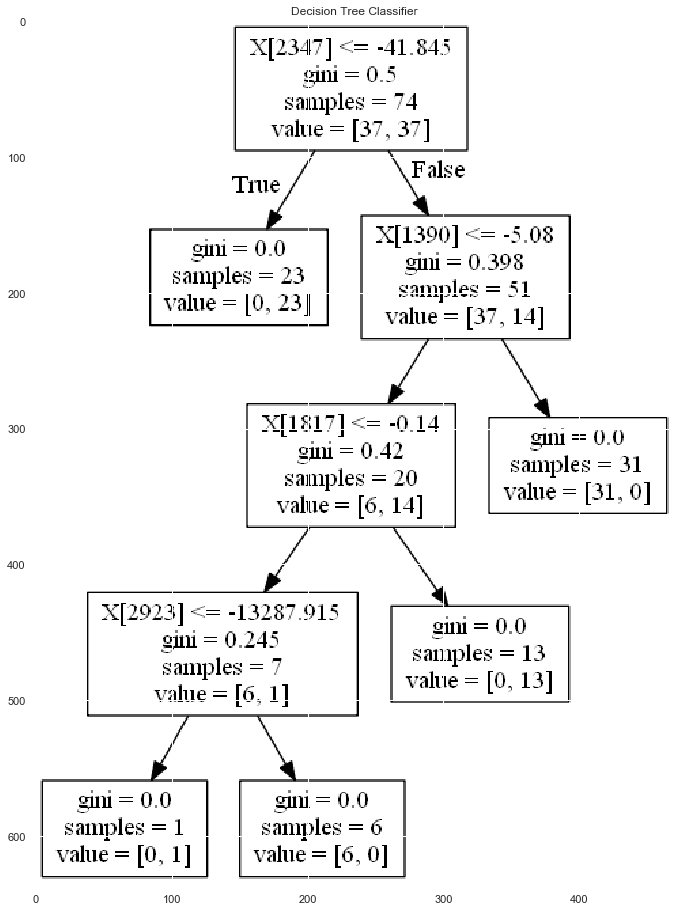

In [13]:
# export to a dot file in the same directory as the notebook
tree.export_graphviz(decTree, out_file='tree.dot')

!! dot -Tpng tree.dot -o tree.png  # convert to png 

import matplotlib.image as mpimg
img=mpimg.imread('tree.png')
plt.imshow(img)
plt.subplots_adjust(left=0.0, right=2.0, bottom=0.0, top=3.0)
plt.title('Decision Tree Classifier')
plt.show()

Here I use SVM classifier using Gaussian RBF kernel and attempting gridsearch to find the best hyperparameters.

In [14]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

params = {'C': [1, 2, 5, 7, 10, 100, 150, 200, 500], 'gamma': [7e-4, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]}

svm_rbf = GridSearchCV(SVC(kernel = 'rbf'), params, scoring = 'accuracy')

svm_rbf.fit(X_train, y_train)

y_score_rbf = svm_rbf.decision_function(X_test)
y_pred_rbf = svm_rbf.predict(X_test)

rbf_acc = metrics.accuracy_score(y_pred = y_pred_rbf, y_true = y_test)
rbf_prec = metrics.precision_score(y_pred = y_pred_rbf, y_true = y_test)
rbf_recall = metrics.recall_score(y_pred = y_pred_rbf, y_true = y_test)
rbf_f1 = metrics.f1_score(y_true = y_test, y_pred = y_pred_rbf)
rbf_auc = metrics.roc_auc_score(y_true = y_test, y_score = y_score_rbf)

print('Using the best parameters for Gaussian RBF', svm_rbf.best_params_)
print('Accuracy {:2.2%}'.format(rbf_acc))
print('Precision score {:2.2%}'.format(rbf_prec))
print('Recall score {:2.2%}'.format(rbf_recall))
print('F1 score {:2.2%}'.format(rbf_f1))


D:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Using the best parameters for Gaussian RBF {'C': 5, 'gamma': 0.5}
Accuracy 73.51%
Precision score 1.97%
Recall score 60.00%
F1 score 3.82%


In [15]:
# This is the KNN or K-Nearest-Neighbors 
from sklearn.neighbors import KNeighborsClassifier

# leave it at the default k=5
neigh = KNeighborsClassifier(n_neighbors=5).fit(X_train, y_train)

neigh_score = metrics.accuracy_score(y_test, neigh.predict(X_test))

print('Accuracy using K-Nearest-Neighbors (k = 5) is ' + f'{neigh_score *100} %')

Accuracy using K-Nearest-Neighbors (k = 5) is 69.2982456140351 %


In [16]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=50).fit(X_train, y_train)

rfc_score = metrics.accuracy_score(y_test, rfc.predict(X_test))

print('Accuracy using Random Forest Classifier is nearly ' + f'{rfc_score *100} %')

Accuracy using Random Forest Classifier is nearly 78.0701754385965 %


Here I will try Multi-Layer perceptron, or a simple deep neural network by scikit-learn to find a better possible estimator.
I will try the Adam Optimization training method and using ReLU for my activation function.

In [17]:
from sklearn.neural_network import MLPClassifier

dnn = MLPClassifier(hidden_layer_sizes=(67, 4,), solver='adam', alpha = 8.0e-4,
                    max_iter = 500, activation='relu', random_state = 42)

dnn.fit(X_train, y_train)

dnn_score = dnn.score(X_test, y_test)

print('Accuracy using this Multi-layer Perceptron is ' + f'{dnn_score * 100} %')

Accuracy using this Multi-layer Perceptron is 74.91228070175438 %


### Summary

We can predict the presense of at least one exoplanet with an accuracy of around 78% using Random Forest. A neural network with a proper number of layers might be able to beat that score but more work needed to find the optimal layer parameters for this dataset.